In [1]:
def inquire_grib_data(path):
    import pygrib                  # gribファイルの中身を見たい場合はinquire_grib_data(path)を実行                
    grbs = pygrib.open(path)
    for grb in grbs:
        print(grb)
    return
def read_grib_data(path,name=None,level=None):
    import numpy as np
    import pygrib                   # pygribは!pip3 install pygrib --userでインストール
    grbs = pygrib.open(path)

    if name != None:                # anl_surf125に対しては変数名を与える
        alines = grbs.select(name=name)
    elif level != None:             # anl_p125に対しては気圧面を与えるとその水平面データ
        alines = grbs.select(level=level)
    else:                           #                  気圧面を与えないと全３次元データ
        alines = grbs.select()

    lat, lon = alines[0].latlons()  # lonは経度、latは緯度データ: (ny,nx)の２次元格子です
    ny, nx = lat.shape
    nline = len(alines)
    gdata = np.empty( (nline,ny,nx), dtype = "f4" )
    levels = np.empty( (nline), dtype = "f4" )
    for iline, aline in enumerate(alines):
        gdata[iline,:,:] = aline.values[::-1,:]
        levels[iline] = aline["level"]

    return lon, lat[::-1], level, gdata 
# inquire_grib_data("anl_surf125.2020010100") # これを実行すると、この下のnameに何を与えるかがわかります
# lon, lat, _, SLP = read_grib_data("anl_surf125.2020010100",name="Mean sea level pressure")
# T850 = read_grib_data("anl_p125_tmp.2020010100",level=850)[3]

In [2]:
def draw_graph(xmesh,ymesh,topo_data):
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs

    fig = plt.figure( figsize = (5,2.5), dpi = 300 )
    proj = ccrs.Mercator(central_longitude=140)
    proj_cart = ccrs.PlateCarree()
    ax = plt.axes((0.1,0.1,0.8,0.8), projection=proj)
    ax.set_extent([120,160,25,50],crs=proj_cart)
    ax.coastlines()
    fig.savefig("等高線")

    C = ax.contourf(xmesh,ymesh,topo_data,cmap="RdYlBu",transform=proj_cart, alpha=0.5)
    fig.colorbar(C)
    return ax

/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/konagai/.local/lib/python3.6/site-packages/cartopy/crs.py:385: ShapelyDep

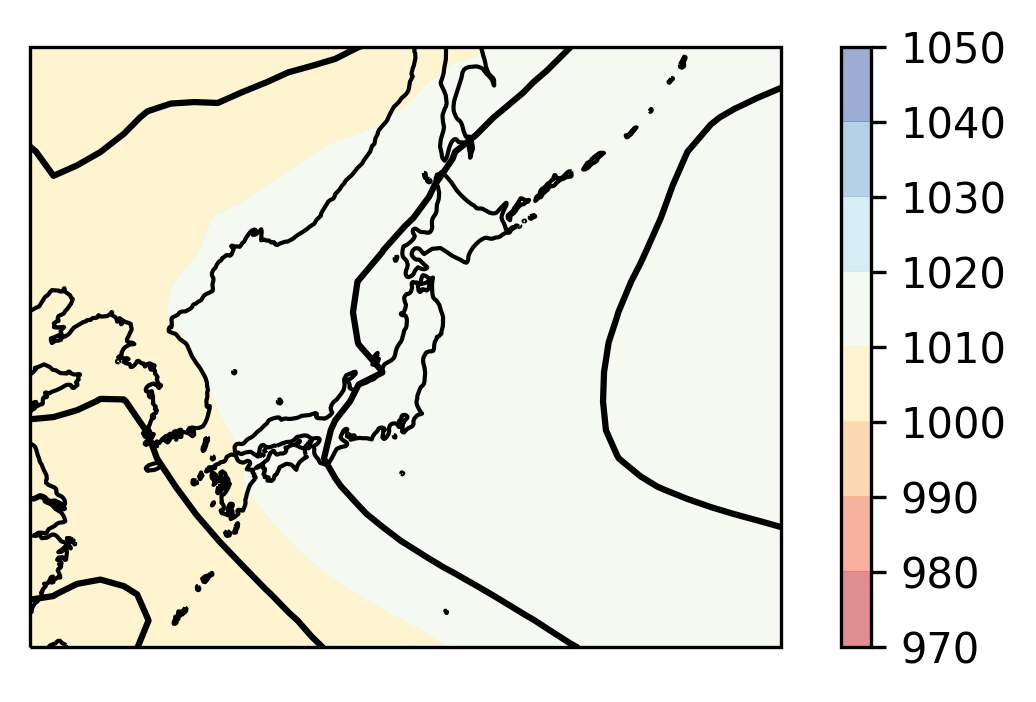

In [5]:
import datetime as dt
import calendar as cal
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# dts=[]
# for m in range(12):
#     month=m+1
#     nmonth=cal.monthrange(2013,month)[1]
#     dts.extend([dt.datetime(2013,month,1,0)+dt.timedelta(hours=6*i) for i in range(nmonth*4)])  #一年分の平均

# slpm=np.zeros((len(dts),145,288))

nmonth=cal.monthrange(2012,8)[1]
dts=[dt.datetime(2012,8,1,0)+dt.timedelta(hours=6*i) for i in range(nmonth*4)]

#parameter_counts = 4
slpm=np.zeros((len(dts),145,288)) #データの置き場所をつくる

for i,dt in enumerate(dts):
    fdir = "/mnt/hwmet-hdd01/Database/JRA55/anl_p125/"
    fname = "/anl_surf125."
    path=dt.strftime(fdir+"%Y%m"+fname+"%Y%m%d%H")
    lon,lat,_,SLP0=read_grib_data(path,name="Mean sea level pressure")
    slpm[i,:,:]=SLP0
    
slpm /= 100
Mean=np.mean(slpm,axis=0)

### ベースの図
ax = draw_graph(lon,lat,Mean)
### 等高線
levels = np.arange(960.0, 1040.1, 4.0)
colors = ['darkblue']
mappable = ax.contour(lon,lat,Mean,levels=levels, colors=["black"], transform=ccrs.PlateCarree())
plt.clabel(mappable, fmt="%4.0f", inline=True)

Mean=np.mean(slpm,axis=0)
plt.show()
#draw_graph(lon,lat,Mean) どっちでもいいっぽい

In [17]:
import datetime as dt
import calendar as cal
import numpy as np
nmonth=cal.monthrange(2012,8)[1]
dts=[dt.datetime(2012,8,1,0)+dt.timedelta(hours=6*i) for i in range(nmonth*4)]

parameter_counts = 4
slpm=np.zeros((len(dts),145,288, parameter_counts)) #データの置き場所をつくる
SLP0 /= 100

for i,dt in enumerate(dts):
    fdir = "/mnt/hwmet-hdd01/Database/JRA55/anl_p125/"
    fname = "/anl_surf125."
    path=dt.strftime(fdir+"%Y%m"+fname+"%Y%m%d%H")
    lon,lat,_, SLP0=read_grib_data(path,name="Mean sea level pressure")
    lon,lat,_, Temperature = read_grib_data(path, name="2 metre temperature")
    lon,lat,_, u_wind = read_grib_data(path, name="10 metre U wind component")
    lon,lat,_, v_wind = read_grib_data(path,name="10 metre V wind component")
    
    slpm[i, :, :, 0]=SLP0
    slpm[i, :, :, 1] = Temperature
    slpm[i, :, :, 2] = u_wind
    slpm[i, :, :, 3] = v_wind
    
slp_mean = np.mean(slpm[:, :, :, 0], axis=0)
temperature_mean = np.mean(slpm[:, :, :, 1], axis=0)
u_wind_mean = np.mean(slpm[:, :, :, 2], axis=0)
v_wind_mean = np.mean(slpm[:, :, :, 3], axis=0)    

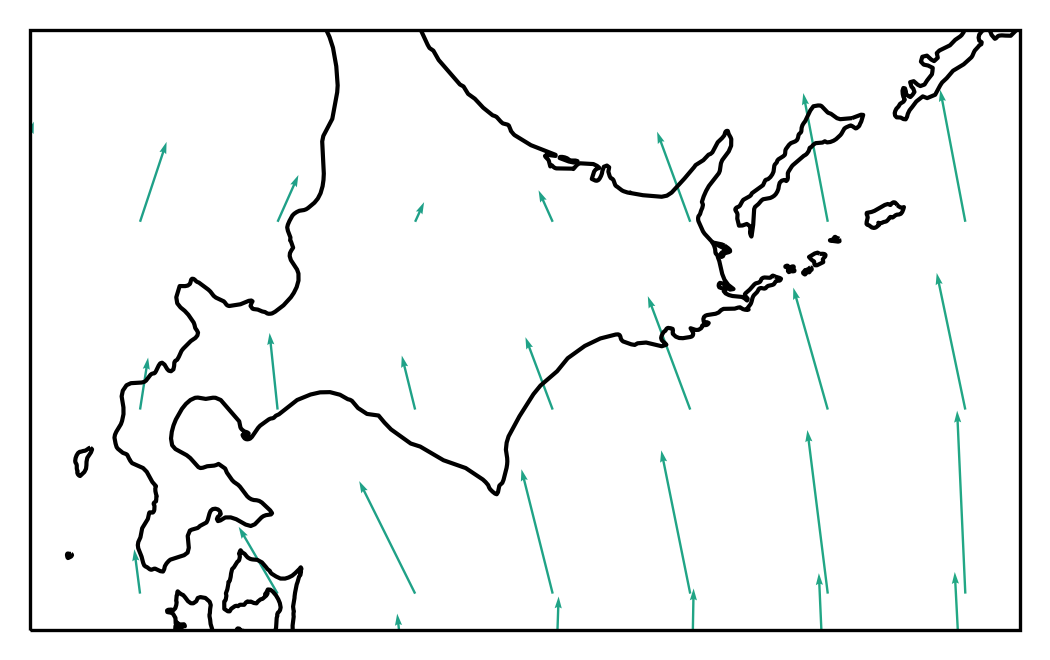

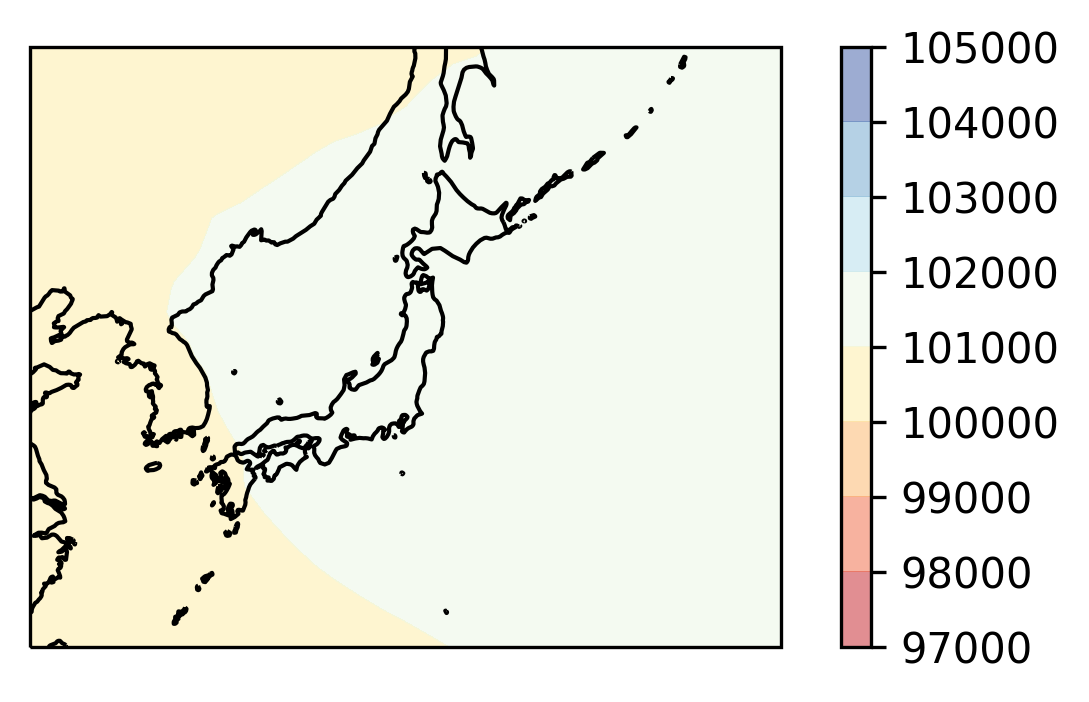

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure( figsize = (5,2.5), dpi = 300 )
proj = ccrs.Mercator(central_longitude=140)
proj_cart = ccrs.PlateCarree()
ax = plt.axes((0.1,0.1,0.8,0.8), projection=proj)
ax.set_extent([139,148,41,45],crs=proj_cart)
ax.coastlines()
fig.savefig("風向→")

ax.quiver(lon, lat, u_wind_mean, v_wind_mean, slp_mean, scale=5, scale_units="inches", transform=ccrs.PlateCarree())

### ベースの図
ax = draw_graph(lon,lat,slp_mean)
### 等高線
levels = np.arange(960.0, 1040.1, 4.0)
colors = ['darkblue']
mappable = ax.contour(lon,lat,slp_mean,levels=levels, colors=["black"], transform=ccrs.PlateCarree())
plt.clabel(mappable, fmt="%4.0f", inline=True)

slpm /= 100
Mean=np.mean(slpm,axis=0)
plt.show()